<a href="https://colab.research.google.com/github/partha1189/machine_learning/blob/master/Sunspot_Activity_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [2]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-08-23 05:17:59--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 173.194.216.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-08-23 05:18:00 (90.7 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [4]:
import csv 
time_step = []
sunspot = []

In [5]:
with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader)
  for row in reader:
    sunspot.append(float(row[2]))
    time_step.append(int(row[0]))

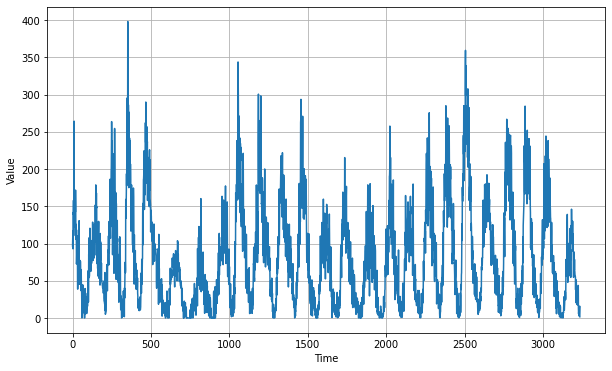

In [6]:
series = np.array(sunspot)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w:w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift =1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape = [None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x : x * 400)
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense_3 (Dense)              (None, None, 30)          1950      
_________________________________________________________________
dense_4 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)          

In [16]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

In [17]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 0s 26ms/step - loss: 81.4328 - mae: 81.9305
Epoch 2/100
12/12 [==============================] - 0s 29ms/step - loss: 80.2591 - mae: 80.7567
Epoch 3/100
12/12 [==============================] - 0s 26ms/step - loss: 78.5311 - mae: 79.0287
Epoch 4/100
12/12 [==============================] - 0s 27ms/step - loss: 76.5364 - mae: 77.0339
Epoch 5/100
12/12 [==============================] - 0s 26ms/step - loss: 74.4509 - mae: 74.9484
Epoch 6/100
12/12 [==============================] - 0s 27ms/step - loss: 72.3866 - mae: 72.8840
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 70.4372 - mae: 70.9347
Epoch 8/100
12/12 [==============================] - 0s 27ms/step - loss: 68.6067 - mae: 69.1043
Epoch 9/100
12/12 [==============================] - 0s 29ms/step - loss: 66.9549 - mae: 67.4526
Epoch 10/100
12/12 [==============================] - 0s 27ms/step - loss: 65.4669 - mae: 65.9646
Epoch 11/100
12/12 [=========

(1e-08, 0.0001, 0.0, 60.0)

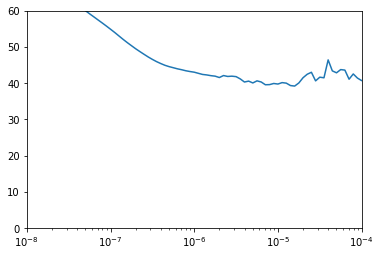

In [18]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer_size=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [21]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 15ms/step - loss: 51.2721 - mae: 51.7700
Epoch 2/500
30/30 [==============================] - 0s 16ms/step - loss: 41.6325 - mae: 42.1297
Epoch 3/500
30/30 [==============================] - 0s 15ms/step - loss: 40.7388 - mae: 41.2361
Epoch 4/500
30/30 [==============================] - 0s 15ms/step - loss: 40.4922 - mae: 40.9893
Epoch 5/500
30/30 [==============================] - 0s 16ms/step - loss: 40.0199 - mae: 40.5170
Epoch 6/500
30/30 [==============================] - 0s 16ms/step - loss: 40.4046 - mae: 40.9018
Epoch 7/500
30/30 [==============================] - 0s 15ms/step - loss: 40.1654 - mae: 40.6627
Epoch 8/500
30/30 [==============================] - 0s 16ms/step - loss: 39.3419 - mae: 39.8390
Epoch 9/500
30/30 [==============================] - 0s 15ms/step - loss: 38.6348 - mae: 39.1317
Epoch 10/500
30/30 [==============================] - 0s 15ms/step - loss: 38.4363 - mae: 38.9334
Epoch 11/500
30/30 [=========

In [22]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time-window_size:-1, -1, 0]

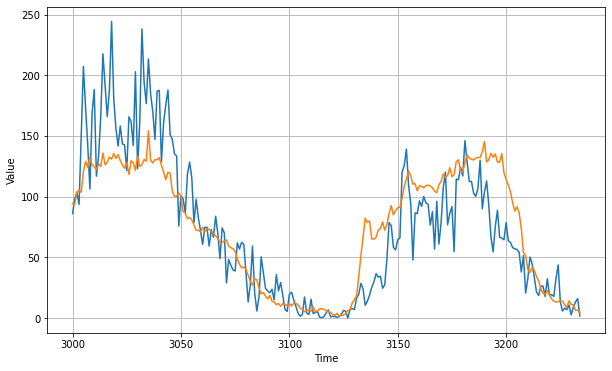

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [24]:
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

23.03772


<Figure size 432x288 with 0 Axes>

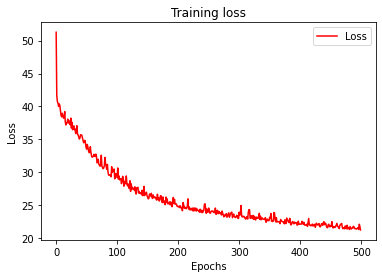

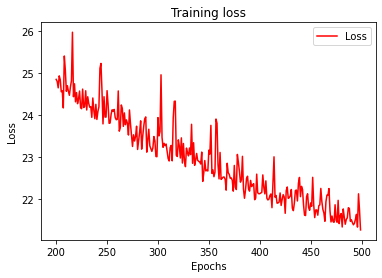

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [26]:
print(rnn_forecast)

[ 94.37761    93.71437   103.47716   105.5613    103.5597    120.68195
 129.024     124.12923   132.59505   125.976494  124.40486   122.125694
 126.98622   124.750946  135.92686   126.22328   128.36873   132.50703
 130.85222   135.61693   131.42877   134.57228   129.71216   126.106384
 123.34836   128.05238   118.23907   129.63722   127.89805   121.60499
 133.42365   124.887314  126.33046   130.58244   129.16841   154.3202
 130.21545   127.63276   130.46632   130.36047   132.11647   125.650635
 120.269966  114.001045  119.98396   119.316086  104.657104  100.19292
 100.23248   103.1441    100.12016    87.73353    86.31291    81.75954
  82.91571    80.74463    76.58854    72.20008    72.23833    70.969185
  74.74388    71.16093    73.03356    73.31588    71.13635    69.21928
  67.76534    65.36879    62.421944   61.99824    63.53941    64.309
  59.209877   57.881077   57.09213    54.81261    48.524933   44.249302
  41.20324    41.98967    40.08925    35.286655   30.324121   26.985872
  3